## Gemeindedatenbank-API via Kafka Producer/Consumer

Auf der Seite https://gedaba.agrarforschung.at/home sind die wichtigsten landwirtschaftlich relevanten Strukturdaten wie Flächen, Tiere, Betriebe, Einwohner, etc. sowie die Nächtigungen enthalten.

Damit umfasst die Datenbank knapp 900 Merkmale mit derzeit ca. 8,5 Mio. Datensätzen. 
Die Daten liegen grundsätzlich ab dem Jahr 2000 auf Gemeindeebene vor, nicht zuordenbare Daten wurden der Hauptstadt der nächst größeren geografischen Einheit zugeordnet. 

Die Seite stellt eine api zur Verfügung, die man über https://gedaba.agrarforschung.at/api/application/query ansprechen kann.

Zunächst werden die nötigen Libraries geladen.

In [6]:
# load important libraries
from time import sleep
from json import dumps
import requests
import json

from kafka import KafkaProducer
from kafka import KafkaConsumer

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import glob

# kafka-host hat Port kafka:9092, weil er gemeinsam mit Spark in einem Container läuft 
kafka_host = 'kafka:9092'

Nun wird der Kafka Producer erzeugt.

In [2]:
# create producer
producer = KafkaProducer(
    bootstrap_servers=kafka_host, #Kafka server
    value_serializer=lambda v: json.dumps(v).encode('utf-8') #json serializer
    )

Auf der Seite findet man die Info, welches Request-Objekt man mitgeben muss, damit man zB die Daten über Weizen abrufen kann, dieses wird dem request mitgegeben (payload):

In [3]:
# value as string
# bundesland in CAPITAL LETTERS
def loadGeDaBaToFile(value, bundesland):
    url = 'https://gedaba.agrarforschung.at/api/application/query'
    headers = {'Content-Type': 'application/json'}
    json_path = 'Klimadaten/data/agrar/data_' +  bundesland + '_' + value + '.json'
    #gedaba_topic = 'gedaba_' + bundesland + '_' + value
    gedaba_topic = 'gedaba_' + '_' + value
    print(json_path)
    
    payload = {'id': 5, 'parameters': [{'name': 'mc_liste', 'value': value}]}
    r = requests.post(url, json=payload, headers=headers)
    input_dict = r.json()['data']['data'] # json.loads(r.json())
    
    # Filter python objects with list comprehensions
    output_dict = [x for x in input_dict if x['bundesland'] == bundesland] # 'bundesland': 'BURGENLAND'
            
    # Transform python object back into json
    output_json = json.dumps(output_dict)
    
    future = producer.send(gedaba_topic, value = output_json)
    try:
        record_metadata = future.get(timeout=10)
    except Exception as ex:
        print('Error: ' + str(ex))
        pass
    
    consumer = KafkaConsumer(
     bootstrap_servers=kafka_host,
     value_deserializer = lambda v: json.loads(v.decode('ascii')),
     auto_offset_reset='earliest'
    )
    consumer.subscribe(topics=gedaba_topic)
    v = next(consumer).value
    j = json.loads(v)
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(j, f)

# get ids:
# 1015, 1016. 1017 (weizen)

In [4]:
for value in ["30", "1015", "1016", "1017"]:
    for bl in ["NIEDERÖSTERREICH"]: # , "NIEDERÖSTERREICH" BURGENLAND
        loadGeDaBaToFile(value, bl)

Klimadaten/data/agrar/data_NIEDERÖSTERREICH_30.json
Error: [Error 10] MessageSizeTooLargeError: The message is 1275153 bytes when serialized which is larger than the maximum request size you have configured with the max_request_size configuration


KeyboardInterrupt: 

Nun wird das Json Objekt in ein Python Objekt umgespeichert, die Daten, die analysiert werden sollen, zB Burgenland werden gefiltert, danach wird wieder zurück nach JSON gespeichert.

Diese Daten werden nun dem Producer übergeben, da es eine große Datenmenge ist, muss in das Objekt future gespeichert werden, damit man ein timeout einstellen kann.

Nun wird der Consumer erzeugt.

Der Consumer "subscribed" das Topic "gedaba", dann werden die Daten lokal gespeichert.

Nun wird eine Sparksession erzeugt und das JSON-Objekt in einen Spark-Dataframe eingelesen:

In [7]:
path = 'Klimadaten/data/agrar/'
files = glob.glob(path + 'data_*.json')

li = []

for f in files:
    spark = SparkSession \
        .builder \
        .appName("Read Data") \
        .getOrCreate()
    spdf = spark.read.json(f)
    df = spdf.toPandas()
    li.append(df)

data = pd.concat(li, axis=0, ignore_index=True)
data

,bkz,bundesland,einheit,gemeindename,gkz5,jahr,mc,merkmal,politischer_bezirk,ressort,wert
0,101,BURGENLAND,ha,Eisenstadt,10101,2000,1015,Winterweichweizen,Eisenstadt(Stadt),BMLRT,205.6200
1,101,BURGENLAND,ha,Eisenstadt,10101,2001,1015,Winterweichweizen,Eisenstadt(Stadt),BMLRT,221.1100
2,101,BURGENLAND,ha,Eisenstadt,10101,2002,1015,Winterweichweizen,Eisenstadt(Stadt),BMLRT,220.2600
3,101,BURGENLAND,ha,Eisenstadt,10101,2003,1015,Winterweichweizen,Eisenstadt(Stadt),BMLRT,179.6500
4,101,BURGENLAND,ha,Eisenstadt,10101,2004,1015,Winterweichweizen,Eisenstadt(Stadt),BMLRT,251.0900
...,...,...,...,...,...,...,...,...,...,...,...
5903,109,BURGENLAND,ha,Badersdorf,10931,2008,30,Weingärten,Oberwart,BMLRT,8.4000
5904,109,BURGENLAND,ha,Badersdorf,10931,2009,30,Weingärten,Oberwart,BMLRT,9.9600
5905,109,BURGENLAND,ha,Badersdorf,10931,2010,30,Weingärten,Oberwart,BMLRT,10.0900
5906,109,BURGENLAND,ha,Badersdorf,10931,2020,30,Weingärten,Oberwart,BMLRT,17.0815


Der Spark-Dataframe wird in einen Panda-Dataframe umgewandelt:

In [10]:
bez = data.groupby(by = ['gemeindename', 'jahr', 'merkmal'], as_index=False)['wert'].sum()
bez

,gemeindename,jahr,merkmal,wert
0,Andau,2000,Hartweizen (Durum),114.5900
1,Andau,2000,Weingärten,445.1000
2,Andau,2000,Winterweichweizen,746.8900
3,Andau,2001,Hartweizen (Durum),82.5200
4,Andau,2001,Weingärten,446.9100
...,...,...,...,...
5903,Zurndorf,2019,Winterweichweizen,1137.6799
5904,Zurndorf,2020,Hartweizen (Durum),121.1629
5905,Zurndorf,2020,Winterweichweizen,811.5777
5906,Zurndorf,2021,Hartweizen (Durum),190.7288


Visualisierung des gruppierten Datensatzes:

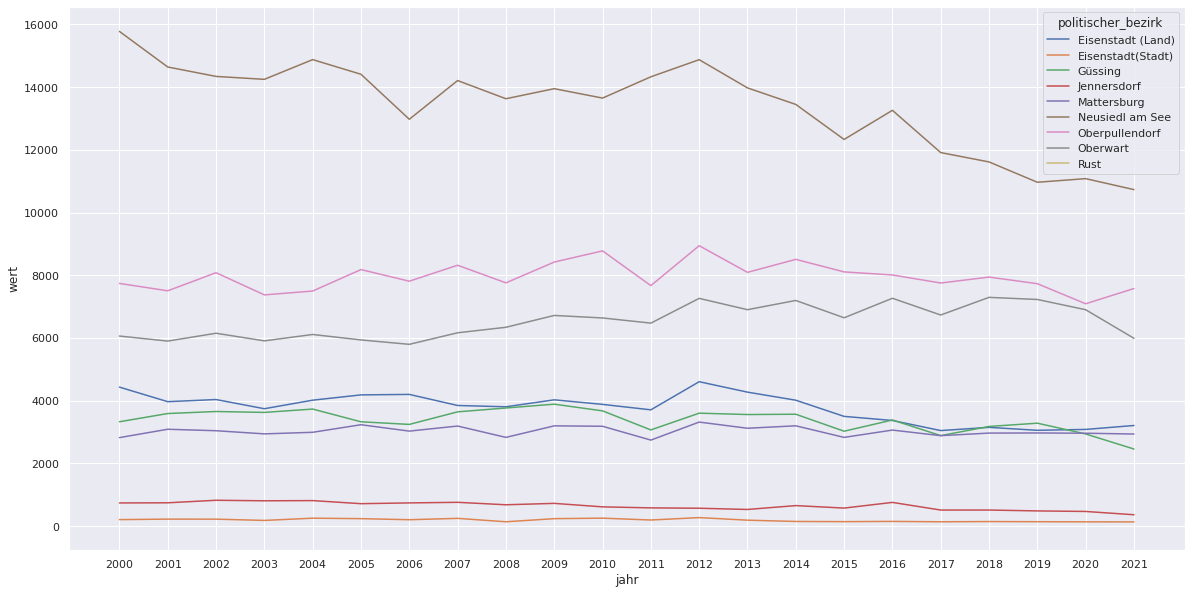

In [18]:
#fig, axes = plt.subplots(figsize=(20,10))
sns.lineplot(data=bez, x="jahr", y="wert", hue="politischer_bezirk")
sns.set(rc={'figure.figsize':(30,20)})

#sns.lineplot(data=df, x="jahr", y="wert", hue="politischer_bezirk", ci=None)
#ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')